In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.interpolate import splrep, BSpline
from src.preprocess import stratify5
import seaborn as sns
from src.aggregate_features import generate_lrtt_features, generate_maf_features
from src.read_data import load_reference_data2

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score


#https://people.stat.sc.edu/hansont/stat740/Pspline.pdf

In [2]:
#LOAD DATASETS
phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')
maf = pd.read_csv('./data/derived/imputed_MAF_data.csv')
ambig = pd.read_csv('./data/derived/ambiguity/ambiguity_genes.csv')

#ADD TSI CATEGORIES
phylo = stratify5(phylo)
maf = stratify5(maf)

#sort by ID and coordinate
phylo = phylo.sort_values(by=['RENAME_ID', 'xcoord'])
maf = maf.sort_values(by=['RENAME_ID', 'Window_Centre'])

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_11083/3512507516.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')


# 1 - PREPARE DATA

In [3]:
#ENCODE STRATA IN FIVE CLASSES
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
phylo['TSI_encoded'] = ordinal_encoder.fit_transform(phylo[['TSI_category']])
maf['TSI_encoded'] = ordinal_encoder.fit_transform(maf[['TSI_category']])

#FIND UNIQUE IDS   
unique_ids = phylo['RENAME_ID'].unique()
#SPLIT BASED ON IDS
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

#TRAIN AND TEST DATASETS
train_phylo = phylo[phylo['RENAME_ID'].isin(train_ids)]
test_phylo = phylo[phylo['RENAME_ID'].isin(test_ids)]
train_maf = maf[maf['RENAME_ID'].isin(train_ids)]
test_maf = maf[maf['RENAME_ID'].isin(test_ids)]
train_ambig = ambig[ambig['RENAME_ID'].isin(train_ids)]
test_ambig = ambig[ambig['RENAME_ID'].isin(test_ids)]

# 2 - BSPLINE SMOOTHING

## knots

In [4]:
import logging

logging.basicConfig(level=logging.INFO)

def bspline_smoothing_automatic_knots(df, x, y, num_knots, smoothing_factor=1):
    try:
        # Ensure the data is sorted
        df = df.sort_values(by=x)
        # Check for NaN values and constant values
        if df[x].isna().any() or df[y].isna().any():
            logging.warning(f"NaN values found in group {df['RENAME_ID'].iloc[0]}")
            return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)
        if df[x].nunique() == 1 or df[y].nunique() == 1:
            logging.warning(f"Constant values found in group {df['RENAME_ID'].iloc[0]}")
            return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)

        # Log min and max values of xcoord for each group
        min_x, max_x = df[x].min(), df[x].max()
        #logging.info(f"Group {df['RENAME_ID'].iloc[0]}: min_x = {min_x}, max_x = {max_x}")

        # Check for low variation in x values
        if max_x - min_x < 1e-5:
            logging.warning(f"Low variation in x values for group {df['RENAME_ID'].iloc[0]}")
            return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)

        # Generate knots
        knots = np.linspace(df[x].min(), df[x].max(), num_knots)[1:-1]
        # Fit B-spline
        t, xi, k = splrep(df[x], df[y], s=smoothing_factor, k=3, t=knots)
        bspline = BSpline(t, xi, k, extrapolate=False)
        smoothed_values = bspline(df[x])
        #logging.info(f"Coefficients for group {df['RENAME_ID'].iloc[0]}: {xi}")

        return smoothed_values, xi
    except Exception as e:
        print(f"Error in B-spline smoothing for {x}, {y} with {num_knots} knots: {e}")
        return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan) # Return NaN if smoothing failed

In [5]:
def apply_smoothing(df, x, y, num_knots):
    smoothed_values = df.groupby('RENAME_ID', group_keys=False).apply(
        lambda group: pd.Series(bspline_smoothing_automatic_knots(group, x, y, num_knots)[0], index=group.index)
    )
    xi = df.groupby('RENAME_ID').apply(
        lambda group: pd.Series(bspline_smoothing_automatic_knots(group, x, y, num_knots)[1])
    )
    return smoothed_values, xi

K = 10

# B-SPLINE SMOOTHING LRTT, MAF12C, AND MAF3C
smoothed_lrtt_train, coefficients_lrtt_train = apply_smoothing(train_phylo, 'xcoord', 'normalised.largest.rtt', K)
smoothed_maf12c_train, coefficients_maf12c_train = apply_smoothing(train_maf, 'Window_Centre', 'MAF12c_Mean', K)
smoothed_maf3c_train, coefficients_maf3c_train = apply_smoothing(train_maf, 'Window_Centre', 'MAF3c_Mean', 4)

smoothed_lrtt_test, coefficients_lrtt_test = apply_smoothing(test_phylo, 'xcoord', 'normalised.largest.rtt', K)
smoothed_maf12c_test, coefficients_maf12c_test = apply_smoothing(test_maf, 'Window_Centre', 'MAF12c_Mean', K)
smoothed_maf3c_test, coefficients_maf3c_test = apply_smoothing(test_maf, 'Window_Centre', 'MAF3c_Mean', 4)

# Adding smoothed values to the DataFrame
train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
train_maf['smoothed_maf12c'] = smoothed_maf12c_train
train_maf['smoothed_maf3c'] = smoothed_maf3c_train

test_phylo['smoothed_lrtt'] = smoothed_lrtt_test
test_maf['smoothed_maf12c'] = smoothed_maf12c_test
test_maf['smoothed_maf3c'] = smoothed_maf3c_test

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_11083/1858220171.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smoothed_values = df.groupby('RENAME_ID', group_keys=False).apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_11083/1858220171.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xi = df.groupby('RENAME_ID').apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ip

## knots optimization?

In [4]:
def adaptive_knot_placement(x, num_knots):
    """
    Place knots adaptively based on the distribution of x.
    """
    percentiles = np.linspace(0, 100, num_knots + 2)[1:-1]
    knots = np.percentile(x, percentiles)
    return knots

def bspline_smoothing_automatic_knots(df, x, y, num_knots, smoothing_factor=1):
    try:
        df = df.sort_values(by=x)
        
        if df[x].isna().any() or df[y].isna().any():
            logging.warning(f"NaN values found in group {df['RENAME_ID'].iloc[0]}")
            return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)
        if df[x].nunique() == 1 or df[y].nunique() == 1:
            logging.warning(f"Constant values found in group {df['RENAME_ID'].iloc[0]}")
            return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)

        knots = adaptive_knot_placement(df[x], num_knots)
        t, xi, k = splrep(df[x], df[y], s=smoothing_factor, k=3, t=knots)
        bspline = BSpline(t, xi, k, extrapolate=False)
        smoothed_values = bspline(df[x])
        return smoothed_values, xi
    
    except Exception as e:
        logging.error(f"Error in B-spline smoothing for group {df['RENAME_ID'].iloc[0]}: {e}")
        return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)

def apply_smoothing(df, x, y, num_knots, smoothing_factor=1):
    results = df.groupby('RENAME_ID', group_keys=False).apply(
        lambda group: pd.Series(bspline_smoothing_automatic_knots(group, x, y, num_knots, smoothing_factor)[0], index=group.index)
    )
    coefficients = df.groupby('RENAME_ID').apply(
        lambda group: pd.Series(bspline_smoothing_automatic_knots(group, x, y, num_knots, smoothing_factor)[1])
    )
    return results, coefficients

In [5]:
# Parameters
K = 10

# B-SPLINE SMOOTHING LRTT, MAF12C, AND MAF3C
smoothed_lrtt_train, coefficients_lrtt_train = apply_smoothing(train_phylo, 'xcoord', 'normalised.largest.rtt', K)
smoothed_maf12c_train, coefficients_maf12c_train = apply_smoothing(train_maf, 'Window_Centre', 'MAF12c_Mean', K)
smoothed_maf3c_train, coefficients_maf3c_train = apply_smoothing(train_maf, 'Window_Centre', 'MAF3c_Mean', 4)

smoothed_lrtt_test, coefficients_lrtt_test = apply_smoothing(test_phylo, 'xcoord', 'normalised.largest.rtt', K)
smoothed_maf12c_test, coefficients_maf12c_test = apply_smoothing(test_maf, 'Window_Centre', 'MAF12c_Mean', K)
smoothed_maf3c_test, coefficients_maf3c_test = apply_smoothing(test_maf, 'Window_Centre', 'MAF3c_Mean', 4)

# Adding smoothed values to the DataFrame
train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
train_maf['smoothed_maf12c'] = smoothed_maf12c_train
train_maf['smoothed_maf3c'] = smoothed_maf3c_train

test_phylo['smoothed_lrtt'] = smoothed_lrtt_test
test_maf['smoothed_maf12c'] = smoothed_maf12c_test
test_maf['smoothed_maf3c'] = smoothed_maf3c_test

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_43728/1412802928.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('RENAME_ID', group_keys=False).apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_43728/1412802928.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coefficients = df.groupby('RENAME_ID').apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/

## plot 1 - SET KNOTS

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_11083/2835423363.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_11083/2835423363.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


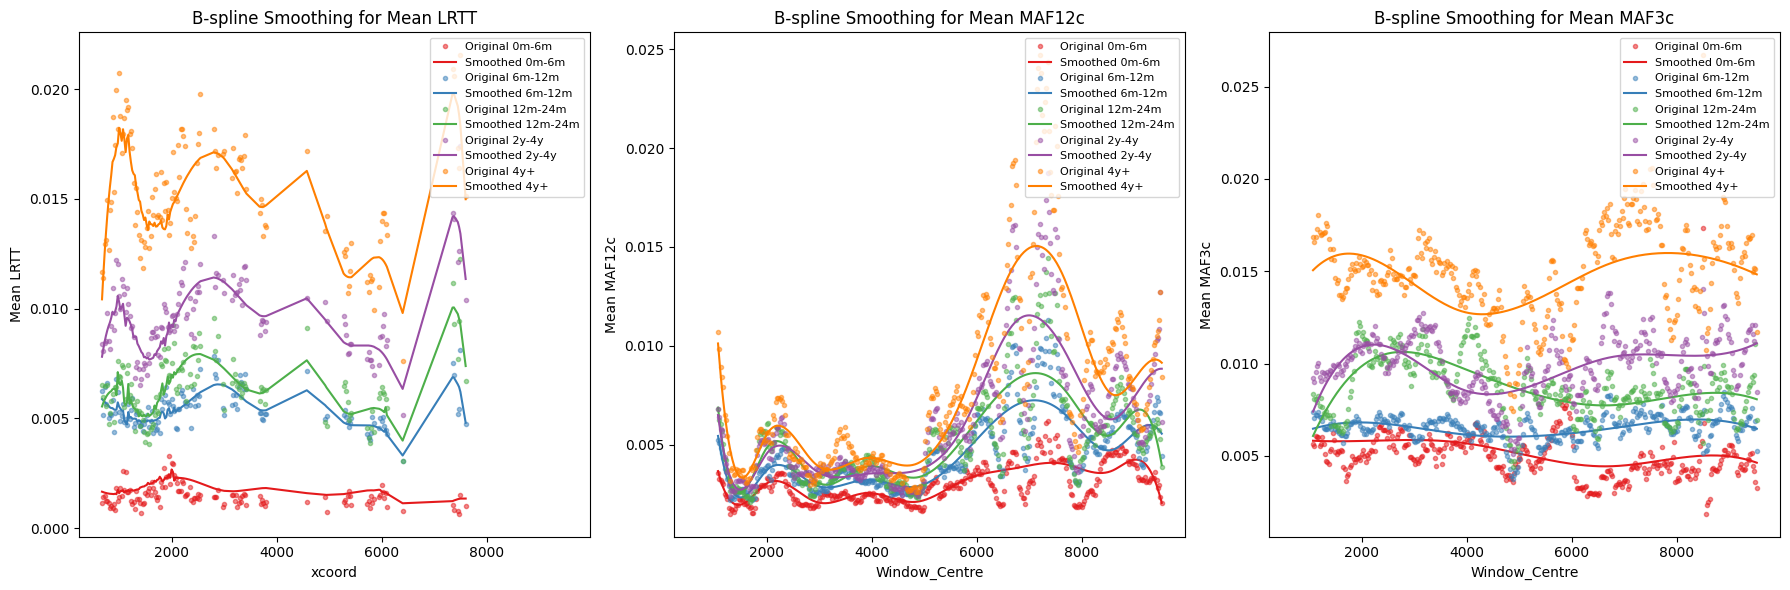

In [8]:
mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()

mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'smoothed_maf12c': 'mean',
    'MAF3c_Mean': 'mean',
    'smoothed_maf3c': 'mean'
}).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for normalised.largest.rtt
for i, category in enumerate(mean_values['TSI_category'].unique()):
    category_df = mean_values[mean_values['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i])

axs[0].set_xlabel('xcoord')
axs[0].set_ylabel('Mean LRTT')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].set_title('B-spline Smoothing for Mean LRTT')

# Plot for MAF12c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[1].plot(category_df['Window_Centre'], category_df['smoothed_maf12c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[1].set_xlabel('Window_Centre')
axs[1].set_ylabel('Mean MAF12c')
axs[1].legend(loc='upper right', fontsize=8)
axs[1].set_title('B-spline Smoothing for Mean MAF12c')

# Plot for MAF3c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[2].plot(category_df['Window_Centre'], category_df['smoothed_maf3c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[2].set_xlabel('Window_Centre')
axs[2].set_ylabel('Mean MAF3c')
axs[2].legend(loc='upper right', fontsize=8)
axs[2].set_title('B-spline Smoothing for Mean MAF3c')

plt.tight_layout()
plt.show()

## plot 2 - ADAPTIVE

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_74251/2109066865.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_phylo = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_74251/2109066865.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


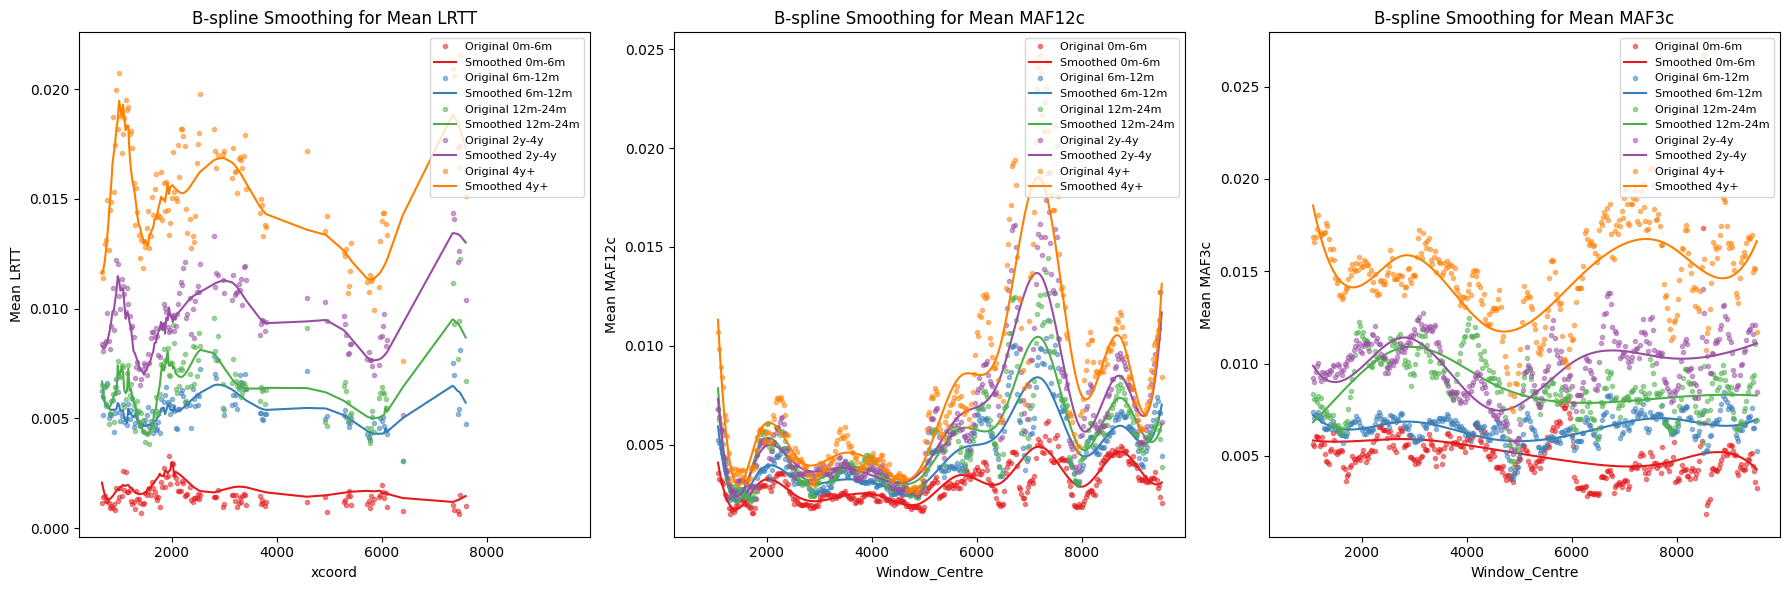

In [36]:
mean_values_phylo = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()

# Calculate the mean values for each category and coordinate in train_maf
mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'smoothed_maf12c': 'mean',
    'MAF3c_Mean': 'mean',
    'smoothed_maf3c': 'mean'
}).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for normalised.largest.rtt
for i, category in enumerate(mean_values_phylo['TSI_category'].unique()):
    category_df = mean_values_phylo[mean_values_phylo['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i])

axs[0].set_xlabel('xcoord')
axs[0].set_ylabel('Mean LRTT')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].set_title('B-spline Smoothing for Mean LRTT')

# Plot for MAF12c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[1].plot(category_df['Window_Centre'], category_df['smoothed_maf12c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[1].set_xlabel('Window_Centre')
axs[1].set_ylabel('Mean MAF12c')
axs[1].legend(loc='upper right', fontsize=8)
axs[1].set_title('B-spline Smoothing for Mean MAF12c')

# Plot for MAF3c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[2].plot(category_df['Window_Centre'], category_df['smoothed_maf3c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[2].set_xlabel('Window_Centre')
axs[2].set_ylabel('Mean MAF3c')
axs[2].legend(loc='upper right', fontsize=8)
axs[2].set_title('B-spline Smoothing for Mean MAF3c')

plt.tight_layout()
plt.show()

### gradient features - not useful

In [43]:
train_phylo['lrtt_gradient'] = np.gradient(train_phylo['smoothed_lrtt'])
train_maf['maf12c_gradient'] = np.gradient(train_maf['smoothed_maf12c'])
train_maf['maf3c_gradient'] = np.gradient(train_maf['smoothed_maf3c'])

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_74251/2012337296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_phylo['lrtt_gradient'] = np.gradient(train_phylo['smoothed_lrtt'])
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_74251/2012337296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_maf['maf12c_gradient'] = np.gradient(train_maf['smoothed_maf12c'])
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_74251/2012337296.py:3: SettingWithCopyWarning: 
A v

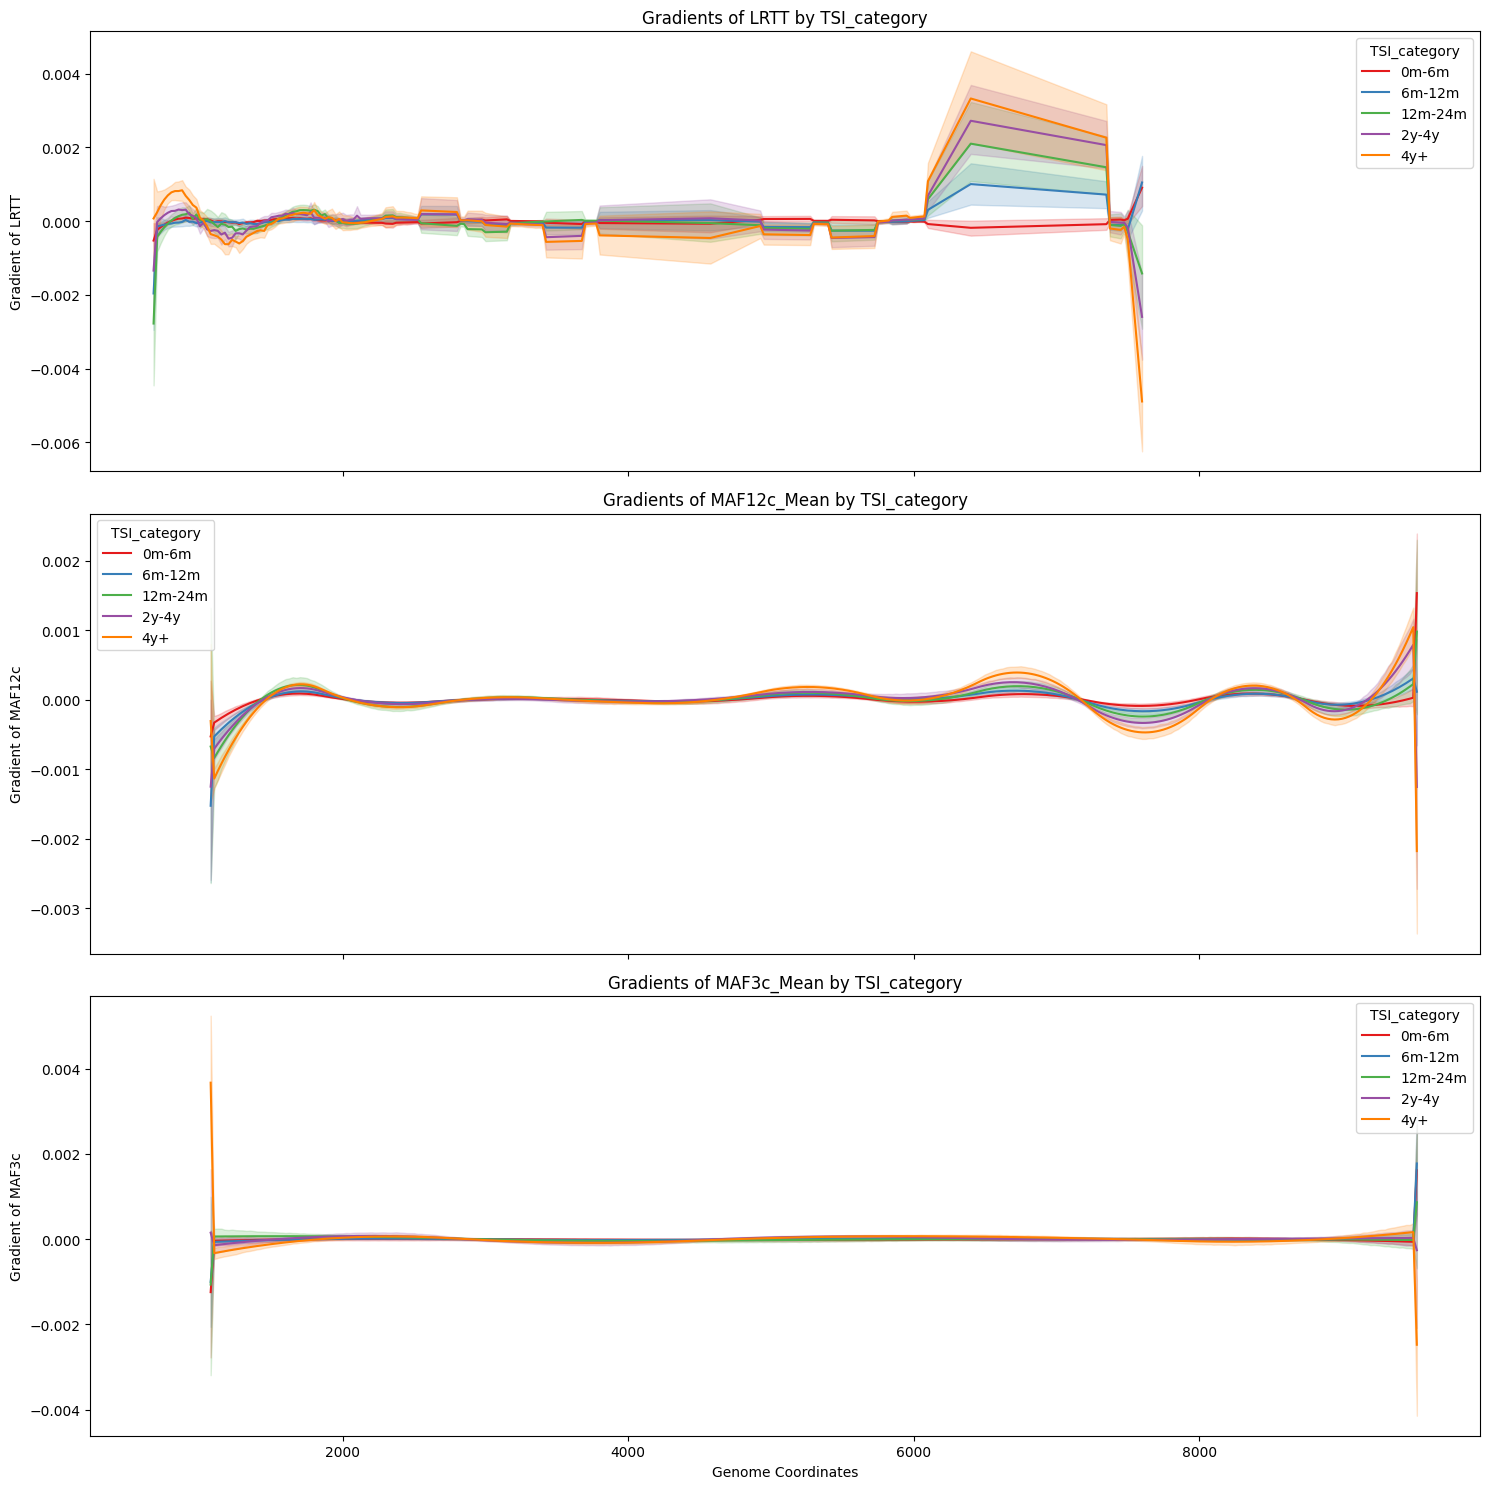

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# Plot for normalised.largest.rtt_gradient
sns.lineplot(data=train_phylo, x='xcoord', y='lrtt_gradient', hue='TSI_category', ax=axs[0], palette='Set1')
axs[0].set_title('Gradients of LRTT by TSI_category')
axs[0].set_xlabel('Genome Coordinates')
axs[0].set_ylabel('Gradient of LRTT')
axs[0].legend(title='TSI_category')

# Plot for MAF12c_Mean_gradient
sns.lineplot(data=train_maf, x='Window_Centre', y='maf12c_gradient', hue='TSI_category', ax=axs[1], palette='Set1')
axs[1].set_title('Gradients of MAF12c_Mean by TSI_category')
axs[1].set_xlabel('Genome Coordinates')
axs[1].set_ylabel('Gradient of MAF12c')
axs[1].legend(title='TSI_category')

# Plot for MAF3c_Mean_gradient
sns.lineplot(data=train_maf, x='Window_Centre', y='maf3c_gradient', hue='TSI_category', ax=axs[2], palette='Set1')
axs[2].set_title('Gradients of MAF3c_Mean by TSI_category')
axs[2].set_xlabel('Genome Coordinates')
axs[2].set_ylabel('Gradient of MAF3c')
axs[2].legend(title='TSI_category')

plt.tight_layout()
plt.show()

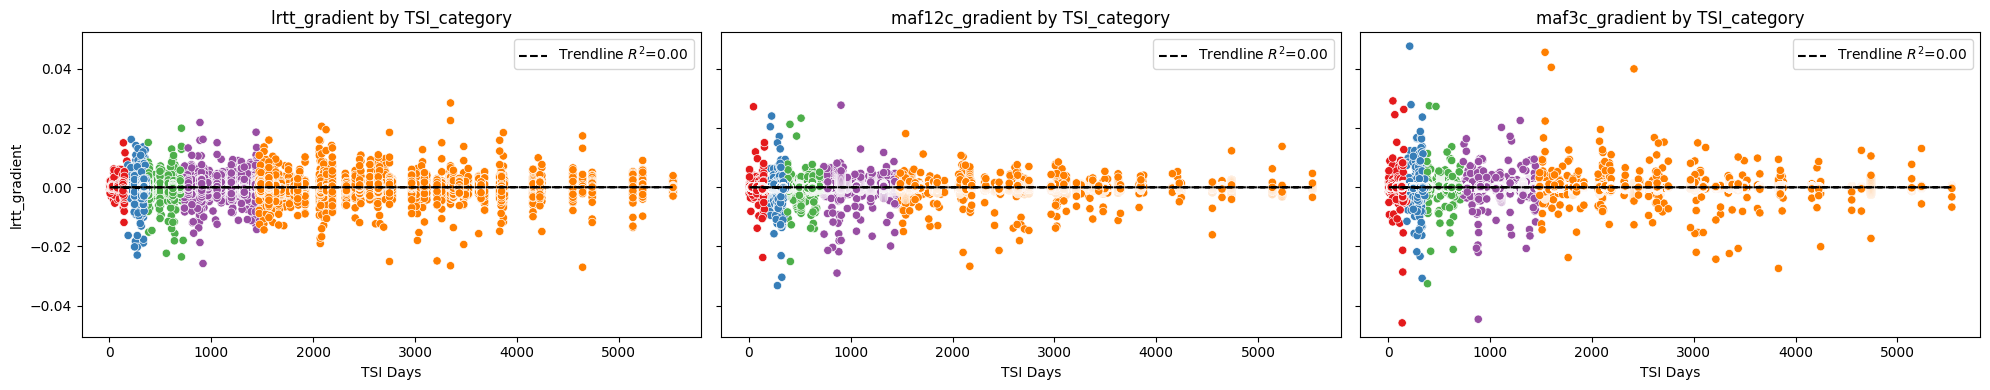

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Features to plot
features_tips = ['lrtt_gradient', 'maf12c_gradient', 'maf3c_gradient']
n_cols = 3
n_rows = int(np.ceil(len(features_tips) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting
for i, feature in enumerate(features_tips):
    ax = axes[i]
    if feature in train_phylo.columns:
        data = train_phylo
    else:
        data = train_maf

    sns.scatterplot(ax=ax, data=data, x='TSI_days', y=feature, hue='TSI_category', palette='Set1', legend=False)
    ax.set_title(f'{feature} by TSI_category')
    ax.set_xlabel('TSI Days')
    ax.set_ylabel(feature)
    
    # Fit a linear regression model
    subset = data.dropna(subset=[feature, 'TSI_days'])
    if len(subset) > 1:  # Ensure there are enough data points
        X = subset[['TSI_days']]
        y = subset[feature]
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        ax.plot(subset['TSI_days'], y_pred, color='black', linestyle='--', label=f'Trendline $R^2$={r2:.2f}')  # trendline
        
        ax.legend()

# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## agreggating features

In [9]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

# Generate aggregated features for train and test datasets separately
train_phylo_features = generate_lrtt_features(train_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')
test_phylo_features = generate_lrtt_features(test_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')

train_maf_features = generate_maf_features(train_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')
test_maf_features = generate_maf_features(test_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')

# Merge the aggregated features
train_features = pd.merge(train_phylo_features, train_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
test_features = pd.merge(test_phylo_features, test_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')

In [10]:
# Finalize the features
train_features = stratify5(train_features)
test_features = stratify5(test_features)

## adding $\xi$ to feature set

In [11]:
def expand_coefficients(df, coeffs, prefix):
    coeffs_df = coeffs.reset_index()
    coeffs_df.columns = [f'{prefix}_coeff_{col}' if col != 'RENAME_ID' else 'RENAME_ID' for col in coeffs_df.columns]
    coeffs_df = coeffs_df.iloc[:, :-4]  # Drop the last four columns
    return pd.merge(df, coeffs_df, on='RENAME_ID', how='left')

# Add coefficients to the aggregated features
train_features = expand_coefficients(train_features, coefficients_lrtt_train, 'lrtt')
train_features = expand_coefficients(train_features, coefficients_maf12c_train, 'maf12c')
train_features = expand_coefficients(train_features, coefficients_maf3c_train, 'maf3c')

test_features = expand_coefficients(test_features, coefficients_lrtt_test, 'lrtt')
test_features = expand_coefficients(test_features, coefficients_maf12c_test, 'maf12c')
test_features = expand_coefficients(test_features, coefficients_maf3c_test, 'maf3c')


## back to normal

In [23]:
# SET Y
target_column = 'TSI_category'

predictor_sets = {
    'Alex': ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips" ,"gp41_maf12c","gp41_maf3c"],
    'Genome': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips'],
    'ENV': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'],
    'GAG_ENV': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips'],
    'All': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_tips',
            'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c'],
    'Genome_ENV_GAG': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c'], 
    'Andrea': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c','gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c']}

In [21]:
def run_forest_class(X_train, y_train, X_test, y_test, predictors, n_estimators=100, random_state=42):
    # Select the predictor columns
    X_train_subset = X_train[predictors]
    X_test_subset = X_test[predictors]

    #DEFINE RANDOM FOREST CLASSIFIER INSTANCE   
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    #FIT RANDOM FOREST CLASSIFIER ON TRAINING DATA 
    rf.fit(X_train_subset, y_train)
    #MAKE PREDICTIONS ON TEST DATA
    y_pred = rf.predict(X_test_subset)

    #COMPUTE CLASSIFICATION ACCURACY 
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

test_split = 0.25

In [24]:
# Classification Model
X_train = train_features.drop(columns=['TSI_category'])
y_train = train_features['TSI_category']
X_test = test_features.drop(columns=['TSI_category'])
y_test = test_features['TSI_category']

results = []

for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_bspline = pd.DataFrame(results)
results_bspline.sort_values(by = 'Accuracy', ascending=False)

,Predictor Set,Accuracy
6,Andrea,0.578947
4,All,0.572368
0,Alex,0.559211
5,Genome_ENV_GAG,0.559211
3,GAG_ENV,0.539474
1,Genome,0.519737
2,ENV,0.473684


## AMBIGUITY

In [12]:
# Merge ambiguity data
train_features = pd.merge(train_features, train_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')
test_features = pd.merge(test_features, test_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')

In [28]:
#SAVE WITH SMOOTHED FEATURES 
'''
FOR SET KNOTS: 

train_features.to_csv('./data/derived/feature_selection/training_data.csv', header = True)
test_features.to_csv('./data/derived/feature_selection/test_data.csv', header = True)

FOR ADAPTIVE KNOTS: 

train_features.to_csv('./data/derived/feature_selection/training_data_adaptive_bspline.csv', header = True)
test_features.to_csv('./data/derived/feature_selection/test_data_adaptive_bspline.csv', header = True)'''

In [29]:
predictor_sets = {
    'Alex':    ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips" ,"gp41_maf12c","gp41_maf3c", 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Genome':  ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig'],
    'ENV':     ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig'],
    'GAG_ENV': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gp120_ambig'],
    'All':     ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_tips',
                'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Genome_ENV_GAG': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'], 
    'Andrea':  ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c','gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Optimal': ['genome_lrtt','genome_tips','gag_lrtt','gag_tips','pol_lrtt','pol_tips',
                'gp120_lrtt', 'gp120_tips', 'genome_maf12c', 'genome_maf3c', 'gag_maf12c',
                'gag_maf3c', 'pol_maf12c', 'pol_maf3c' ,'gp120_maf12c' ,'gp120_maf3c',
                'gp41_maf12c' ,'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig',
                'gp120_ambig']}

# Classification Model
X_train = train_features.drop(columns=['TSI_category'])
y_train = train_features['TSI_category']
X_test = test_features.drop(columns=['TSI_category'])
y_test = test_features['TSI_category']

results = []
for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

    Predictor Set  Accuracy
0            Alex  0.587097
6          Andrea  0.587097
5  Genome_ENV_GAG  0.567742
7         Optimal  0.548387
1          Genome  0.516129
3         GAG_ENV  0.516129
4             All  0.509677
2             ENV  0.445161


In [31]:
predictor_sets = {
    'Alex':           ["gag_lrtt", "gag_tips", "gag_maf3c", 
                        "pol_lrtt", 
                        "gp120_lrtt", "gp120_tips", 
                        "gp41_tips" ,"gp41_maf12c", "gp41_maf3c"],
    'Genome':         ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips'],
    'ENV':            ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'],
    'GAG_ENV':        ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                       'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips'],
    'All':            ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                        'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 
                        'pol_lrtt', 'pol_tips', 'pol_maf12c', 'pol_maf3c', 
                        'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 
                        'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c'],
    'Genome_ENV_GAG': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                       'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 
                       'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'], 
    'Andrea':          ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c',
                        'gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 
                        'gp41_maf3c']}

In [39]:
# Encode the TSI_category
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
train_features['TSI_encoded'] = ordinal_encoder.fit_transform(train_features[['TSI_category']])
test_features['TSI_encoded'] = ordinal_encoder.fit_transform(test_features[['TSI_category']])

10


# FEATURE IMPORTANCE

In [156]:
def train_and_get_feature_importance(X_train, y_train, predictors):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train[predictors], y_train)
    feature_importance = pd.DataFrame({'feature': predictors, 'importance': rf.feature_importances_})
    return rf, feature_importance

# Function to plot feature importance
def plot_feature_importance(feature_importance, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.sort_values(by='importance', ascending=False))
    plt.title(title)
    plt.show()

In [165]:
target_column = 'TSI_encoded'
class_distribution = train_features[target_column].value_counts()
print("Class distribution in training data:\n", class_distribution)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(train_features, train_features[target_column]):
    stratified_train_features = train_features.iloc[train_index]
    stratified_test_features = train_features.iloc[test_index]
    break  # Using only the first split for simplicity

# Check class distribution again
stratified_class_distribution = stratified_train_features[target_column].value_counts()
print("Class distribution after stratified split:\n", stratified_class_distribution)


Class distribution in training data:
 TSI_encoded
1.0    134
4.0    109
0.0     97
3.0     83
2.0     50
Name: count, dtype: int64
Class distribution after stratified split:
 TSI_encoded
1.0    107
4.0     87
0.0     78
3.0     66
2.0     40
Name: count, dtype: int64


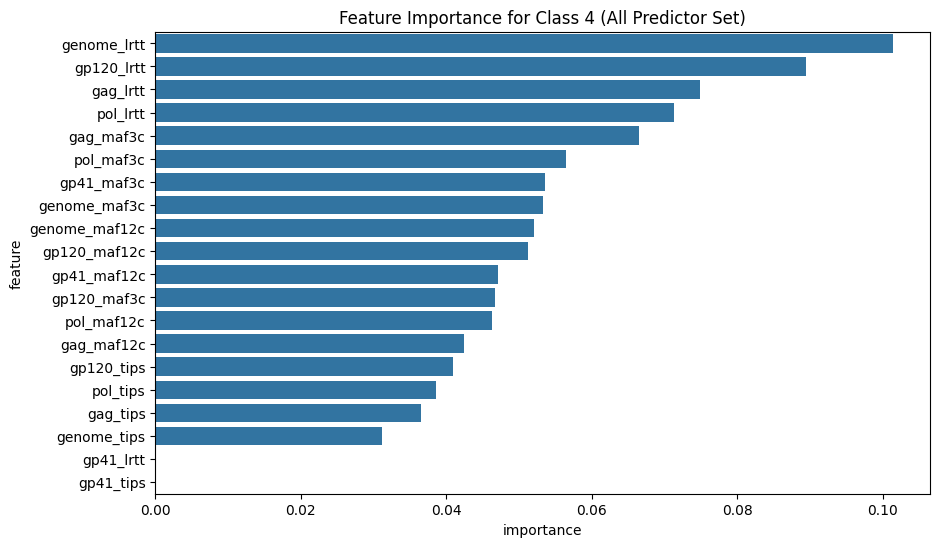

In [167]:
# Train the model on stratified data
rf_all, _ = train_and_get_feature_importance(stratified_train_features, stratified_train_features[target_column], predictor_sets['All'])

# Ensure class 4 is present in the model classes
if 4 in rf_all.classes_:
    class_4_feature_importance = get_class_feature_importance(rf_all, stratified_train_features[predictor_sets['All']], stratified_train_features[target_column], 4)
    plot_feature_importance(class_4_feature_importance, "Feature Importance for Class 4 (All Predictor Set)")
else:
    print("Class 4 is not present in the trained model's classes.")

# BALANCED RANDOM FOREST CLASSIFIER

In [19]:
from imblearn.ensemble import BalancedRandomForestClassifier
#https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-25#Sec2